<a href="https://colab.research.google.com/github/Millimono/DEEP-LERANING/blob/main/Traduction_fran_Poular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [3]:
# import pandas as pd

# # Lisez le fichier Excel
# excel_file_path = "/content/Pular - francais.xlsx"
# df = pd.read_excel(excel_file_path)

# # Sauvegardez le DataFrame en tant que fichier CSV
# csv_file_path = "/content/Pular-fra.csv"
# df.to_csv(csv_file_path, index=False, header=True, sep='\t')

# print("Fichier CSV créé avec succès à", csv_file_path)


In [4]:
# text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [5]:
text_dataset = tf.data.TextLineDataset("/content/pular_v12_fr.txt")

In [6]:
# text_dataset = tf.data.TextLineDataset("/content/pular_v1_fr.txt", encoding="ISO-8859-1")

In [7]:
count = 0

for _ in text_dataset:
    count += 1

print(count)

211


In [8]:
text_dataset.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [9]:
for i in text_dataset.take(3):
  print(i)

tf.Tensor(b'Pular\tFran\xc3\xa7ais', shape=(), dtype=string)
tf.Tensor(b'A n\xe2\x80\x99da hala fran\xc3\xa7ais \t parlez-vous fran\xc3\xa7ais.', shape=(), dtype=string)
tf.Tensor(b'A fini \t tu es r\xc3\xa9veill\xc3\xa9.', shape=(), dtype=string)


In [10]:
# for i in text_dataset.take(210):
#   print(len(tf.strings.split(i," ")))

In [11]:
VOCAB_SIZE=300
ENGLISH_SEQUENCE_LENGTH=15
FRENCH_SEQUENCE_LENGTH=15
EMBEDDING_DIM=250
BATCH_SIZE=15

In [12]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [13]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [14]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [15]:
split_dataset=text_dataset.map(selector)

In [16]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [17]:
init_dataset=text_dataset.map(separator)

In [18]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Pular'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Fran\xc3\xa7ais'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Fran\xc3\xa7ais endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'A n\xe2\x80\x99da hala fran\xc3\xa7ais '], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken  parlez-vous fran\xc3\xa7ais.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' parlez-vous fran\xc3\xa7ais. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'A fini '], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken  tu es r\xc3\xa9veill\xc3\xa9.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' tu es r\xc3\xa9veill\xc3\xa9. endtoken'], dtype=object)>)


In [19]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [20]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y,z and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [21]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [22]:
split_dataset


<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [23]:
dataset=split_dataset.map(vectorizer)

In [24]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Pular'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Fran\xc3\xa7ais'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Fran\xc3\xa7ais endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'A n\xe2\x80\x99da hala fran\xc3\xa7ais '], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken  parlez-vous fran\xc3\xa7ais.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' parlez-vous fran\xc3\xa7ais. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'A fini '], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken  tu es r\xc3\xa9veill\xc3\xa9.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b' tu es r\xc3\xa9veill\xc3\xa9. endtoken'], dtype=object)>)


In [25]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 15), dtype=int64, numpy=array([[55,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 15), dtype=int64, numpy=array([[ 2, 63,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>}, <tf.Tensor: shape=(1, 15), dtype=int64, numpy=array([[63,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>)


In [26]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>

In [27]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>

In [29]:
NUM_BATCHES=int(250/BATCH_SIZE)

In [30]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [31]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>

## Modeling

In [32]:
NUM_UNITS=256

In [33]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 250)      75000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 250)      75000       ['input_2[0][0]']                
                                                                                              

In [34]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [35]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),)
    # metrics='accuracy'
    #metrics=[BLEU()],
    #run_eagerly=True)

In [36]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/translation/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)

In [37]:
# metric = 'val_accuracy'
# ModelCheckpoint(filepath=r"C:\Users\reda.elhail\Desktop\checkpoints\{}".format(Name), monitor=metric,
#                     verbose=2, save_best_only=True, mode='max')]

In [38]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[model_checkpoint_callback])
# for key in history.history:
#   print(key)

Epoch 1/50
14/14 [==============================] - 14s 360ms/step - loss: 4.1548 - val_loss: 1.1129
Epoch 2/50
14/14 [==============================] - 2s 112ms/step - loss: 1.7687 - val_loss: 1.4986
Epoch 3/50
14/14 [==============================] - 2s 98ms/step - loss: 1.4031 - val_loss: 3.1944
Epoch 4/50
14/14 [==============================] - 1s 62ms/step - loss: 1.2538 - val_loss: 1.4509
Epoch 5/50
14/14 [==============================] - 1s 67ms/step - loss: 1.1512 - val_loss: 0.7948
Epoch 6/50
14/14 [==============================] - 1s 44ms/step - loss: 1.1038 - val_loss: 0.5430
Epoch 7/50
14/14 [==============================] - 1s 56ms/step - loss: 1.0645 - val_loss: 1.0543
Epoch 8/50
14/14 [==============================] - 1s 35ms/step - loss: 1.0427 - val_loss: 0.8173
Epoch 9/50
14/14 [==============================] - 1s 31ms/step - loss: 1.0239 - val_loss: 0.9351
Epoch 10/50
14/14 [==============================] - 0s 29ms/step - loss: 1.0054 - val_loss: 0.5066
Epoch 

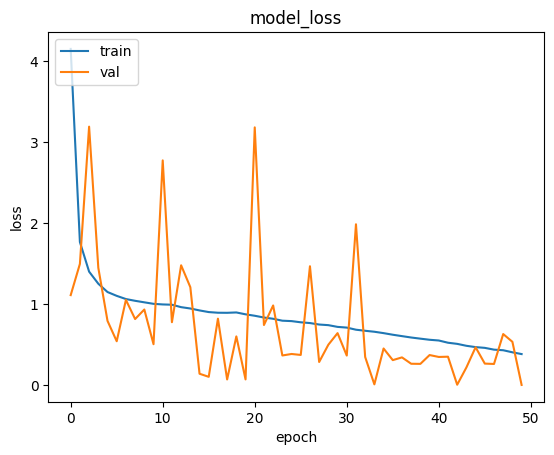

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model_accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

## EVALUATION

In [41]:
seq2seq_gru.evaluate(val_dataset)

1/1 [==============================] - 0s 209ms/step - loss: 0.3092


0.30919334292411804

## Evaluation

In [42]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [43]:
index_to_word

{0: '',
 1: '[UNK]',
 2: 'starttoken',
 3: 'endtoken',
 4: 'de',
 5: 'le',
 6: 'la',
 7: 'à',
 8: 'je',
 9: 'du',
 10: 'pas',
 11: 'des',
 12: 'tu',
 13: 'par',
 14: 'ne',
 15: 'enfant',
 16: 'c’est',
 17: 'suis',
 18: 'femme',
 19: 'et',
 20: 'enfants',
 21: 'en',
 22: 'au',
 23: 'tout',
 24: 'se',
 25: 'saison',
 26: 'que',
 27: 'les',
 28: 'diéri',
 29: 'dieu',
 30: 'bétail',
 31: 'bien',
 32: '‘enfant',
 33: 'être',
 34: 'ça',
 35: 'zones',
 36: 'via',
 37: 'vallée',
 38: 'une',
 39: 'très',
 40: 'troupeau',
 41: 'tenir',
 42: 'son',
 43: 'sens',
 44: 'santé',
 45: 'reposer',
 46: 'qui',
 47: 'père',
 48: 'publique',
 49: 'préhivernage',
 50: 'pour',
 51: 'peuls',
 52: 'personne',
 53: 'parenté',
 54: 'noir',
 55: 'moi',
 56: 'mariage',
 57: 'marché',
 58: 'l',
 59: 'j’ai',
 60: 'illégitime',
 61: 'froid',
 62: 'fraîche',
 63: 'français',
 64: 'fouet',
 65: 'ferlo',
 66: 'est',
 67: 'demain',
 68: 'dans',
 69: 'cousin',
 70: 'chasseur',
 71: 'besoin',
 72: 'beauparent',
 73: 'aîné'

In [44]:
index_to_word[12]

'tu'

In [45]:
french_vectorize_layer

In [53]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    # print(current_word)
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [58]:
translator('Bajjo')

1/1 [==============================] - 0s 23ms/step


'enfant unique'

In [48]:
def translator(english_sentence):
    tokenized_english_sentence=english_vectorize_layer([english_sentence])
    shifted_target='starttoken'
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_sentence=tf.argmax(output,axis=-1)
    return french_sentence

In [49]:
translator('A n’da hala français Aanani Adjarama Ardaade')

1/1 [==============================] - 0s 34ms/step


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=array([[58,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>

In [50]:
translator('A n’da hala français Aanani Adjarama Ardaade').shape

1/1 [==============================] - 0s 33ms/step


TensorShape([1, 15])

In [51]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}